In [16]:
# ------------------------------------------------------------------------------ #
# @Author:        F. Paul Spitzner
# @Email:         paul.spitzner@ds.mpg.de
# @Created:       2023-05-22 12:37:39
# @Last Modified: 2023-05-22 13:45:32
# ------------------------------------------------------------------------------ #
# Notes:
#
# --> Data is in Matlab *.mat – I hope this works for you?
# --> The data includes spike times from a ~20 min recording, the pigeon was in resting state.
# --> The recording took place ~2.5 hours after penetration, there should be minimal drift at this time in the recording.
# --> Spike times are in seconds.
# --> Sampling rate was 30kHz.
# --> Includes 236 neurons.
# --> Putatively, 110 neurons were sampled from the input structure (entopallium) and 126 neurons from MVL and NI, the 2nd and 3rd structures respectively.  At this point, you should take the area separation with a grain of salt since we need to confirm this. That is also the reason why we have not yet separated MVL and NI (these are much thinner regions than entopallium.
# --> Sorting was initially done by Kilosort 2.0, data was then curated manually.
# --> "good" refers to single-unit.  "mua" referes to multi-unit activity.
# --> During the recording online filtering was applied (0.1 Hz-3kHz).
# --> the recording was free of common noise (50 Hz).
# --> The animal was head-fixed, therefore no motion artifact is expected.
#
# ------------------------------------------------------------------------------ #

In [1]:


import scipy.io
mat = scipy.io.loadmat('SPP2205.mat')

# trying to figure out which column is what
n_id = 1
spikes = mat["data"][0][n_id][0]
status = mat["data"][0][n_id][2][0]
readout_n_id = mat["data"][0][n_id][3] # maybe?

# create a dict for every neuron
prepped = dict()
data = mat["data"][0]


prepped[n_id] = dict()
for n_id in range(0, len(data)):
    prepped[n_id] = dict()
    prepped[n_id]["spikes"] = data[n_id][0].flatten()
    prepped[n_id]["status"] = data[n_id][2][0]
    prepped[n_id]["readout_n_id"] = data[n_id][3][0,0]

In [2]:
import numpy as np

def _binned_spike_count(spiketimes, bin_size):
    # reshape to n_id x spikes, in case we only get one neuron
    try:
        if len(spiketimes.shape) == 1:
            spiketimes = spiketimes[np.newaxis, :]
    except AttributeError:
        spiketimes = np.array(spiketimes)[np.newaxis, :]

    num_n = len(spiketimes)

    t_min = np.inf
    t_max = 0

    for n_id in range(0, num_n):
        t_min = min(t_min, np.nanmin(spiketimes[n_id]))
        t_max = max(t_max, np.nanmax(spiketimes[n_id]))

    num_bins = int((t_max - t_min) / bin_size) + 1
    counts = np.zeros(shape=(num_n, num_bins))

    for n_id in range(0, num_n):
        train = spiketimes[n_id]
        for t in train:
            if not np.isfinite(t):
                break
            # do you want to align to a global min or to a local one?
            # irrelevant if processing single neurons
            # t_idx = int((t - t_min) / bin_size) # global
            t_idx = int((t - train[0]) / bin_size) # local, by train
            counts[n_id, t_idx] += 1

    return counts

In [80]:
mat['data']

array([[(array([[2.55000000e-02],
       [9.14333333e-02],
       [1.23733333e-01],
       ...,
       [1.16657637e+03],
       [1.16658553e+03],
       [1.16662700e+03]]), MatlabOpaque([(b'', b'MCOS', b'string', array([[3707764736],
       [         2],
       [         1],
       [         1],
       [         1],
       [         1]], dtype=uint32))],
             dtype=[('s0', 'O'), ('s1', 'O'), ('s2', 'O'), ('arr', 'O')]), array(['mua'], dtype='<U3'), array([[1]], dtype=uint8), array([[12]], dtype=uint8)),
        (array([[5.06333333e-02],
       [2.01133333e-01],
       [2.45500000e-01],
       ...,
       [1.16641927e+03],
       [1.16648947e+03],
       [1.16652123e+03]]), MatlabOpaque([(b'', b'MCOS', b'string', array([[3707764736],
       [         2],
       [         1],
       [         1],
       [         2],
       [         1]], dtype=uint32))],
             dtype=[('s0', 'O'), ('s1', 'O'), ('s2', 'O'), ('arr', 'O')]), array(['good'], dtype='<U4'), array([[3]], dtype=ui

PROGRESS   0%|          | 0/8 [00:00<?]2023-05-22 14:14:13,503 | WARNING  | py.warnings  | /home/lucas/anaconda2/envs/hierarchy_signatures/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in exp

2023-05-22 14:14:13,539 | DEBUG    | notebook     | one timescales fit from 0.03 to 1: [0.02952103 0.04932503 0.00189226]
2023-05-22 14:14:13,540 | DEBUG    | notebook     | two timescales fit from 0.03 to 1: [ 3.16837312e-02 -4.72710384e-02 -1.51333915e+00 -1.28645329e-03]


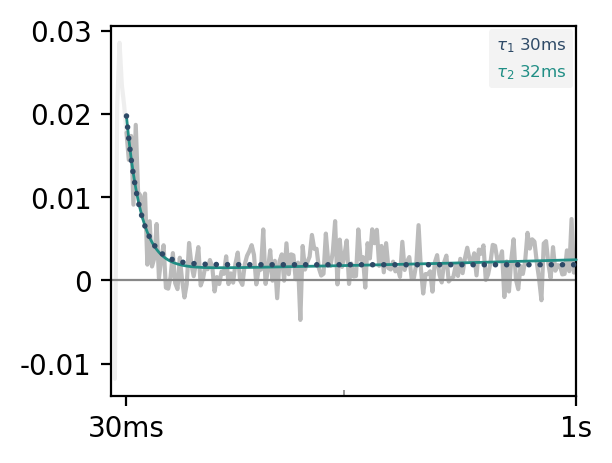

In [5]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import logging
import mrestimator as mre

# enalbe retina resolution in jupyter
%config InlineBackend.figure_format = 'retina'


log = logging.getLogger("notebook")
log.setLevel(logging.DEBUG)
logging.basicConfig(
    format="%(asctime)s | %(levelname)-8s | %(name)-12s | %(message)s",
    level=logging.WARNING,
)
logging.getLogger("mrestimator.utility").setLevel("ERROR")


def fit_two_ts(rk):
    def _f_two_timescales(k, tau1, A1, tau2, A2):
        return np.abs(A1) * np.exp(-k / tau1) + np.abs(A2) * np.exp(-k / tau2)

    # tau1, A1, tau2, A2
    fitpars = np.array(
        [
            (0.1, 0.01, 10, 0.01),
            (0.1, 0.1, 10, 0.01),
            (0.5, 0.01, 10, 0.001),
            (0.5, 0.1, 10, 0.01),
            (0.1, 0.01, 10, 0),
            (0.1, 0.1, 10, 0),
            (0.5, 0.01, 10, 0),
            (0.5, 0.1, 10, 0),
        ]
    )

    fit = mre.fit(rk, fitpars=fitpars, fitfunc=_f_two_timescales)
    tau_1 = fit.popt[0]
    A_1 = np.abs(fit.popt[1])
    tau_2 = fit.popt[2]
    A_2 = np.abs(fit.popt[3])

    # Choose the timescale with higher coefficient A
    tau_selected = (tau_1, tau_2)[np.argmax((A_1, A_2))]
    tau_rejected = (tau_1, tau_2)[np.argmin((A_1, A_2))]
    A_selected = np.amax((A_1, A_2))
    A_rejected = np.amin((A_1, A_2))

    return {
        "fit": fit,
        "tau_selected": tau_selected,
        "A_selected": A_selected,
        "tau_rejected": tau_rejected,
        "A_rejected": A_rejected,
    }


def panel(binned_spt, tmin, tmax, bin_size, dtunit="", clr_1 = "#2E4A67", clr_2 = "#208E85", ax=None, legtitle=None):
    """
    create a single panel with C(T) and two fit approaches
    tmin, tmax in seconds

    needs some global variables to be defined (e.g. bin_size)
    """
    # I know, we are recalculating this although we _should_ be able to mask after
    # calculatating rk. But way back I did not want to allow changing rks for safety.
    rk = mre.coefficients(
        mre.input_handler(binned_spt),
        method="ts",
        steps=(int(tmin / bin_size), int(tmax / bin_size)),
        dt=bin_size,
        dtunit=dtunit,
    )

    # it may be useful to see the rk that are cut away, at least on the left.
    rk_nf = mre.coefficients(
        mre.input_handler(binned_spt),
        method="ts",
        steps=(0, int(tmin / bin_size)),
        dt=bin_size,
        dtunit=dtunit,
    )

    # tau, A, O
    fitpars = np.array([(0.1, 0.01, 0), (0.1, 0.1, 0), (1, 0.01, 0), (1, 0.1, 0)])
    single_timescale_fit = mre.fit(rk, fitfunc="exponential_offset", fitpars=fitpars)

    _two_ts_fit = fit_two_ts(rk)
    two_timescales_fit = _two_ts_fit["fit"]
    tau_two_timescales = _two_ts_fit["tau_selected"]

    if ax is None:
        fig, ax = plt.subplots(figsize=(3.0, 2.4))
    else:
        fig = ax.get_figure()

    # rasterize the rks, to not kill pdf renderer!
    ax.set_rasterization_zorder(1.5)

    ax.plot(
        rk.steps * rk.dt,
        rk.coefficients,
        color="#BBB",
        solid_capstyle="round",
        zorder=1,
    )

    ax.plot(
        rk_nf.steps * rk_nf.dt,
        rk_nf.coefficients,
        color="#EEE",
        solid_capstyle="round",
        zorder=0.5,
    )

    fit = single_timescale_fit
    ax.plot(
        fit.steps * fit.dt,
        fit.fitfunc(fit.steps * fit.dt, *fit.popt),
        color=clr_1,
        solid_capstyle="round",
        dash_capstyle="round",
        ls=(0, (0.01, 2)),
        lw=2,
        clip_on=False,
        zorder=4,
    )
    log.debug(f"one timescales fit from {tmin} to {tmax}: {fit.popt}")

    fit = two_timescales_fit
    ax.plot(
        fit.steps * fit.dt,
        fit.fitfunc(fit.steps * fit.dt, *fit.popt),
        color=clr_2,
        lw=1.0,
        dash_capstyle="round",
        solid_capstyle="round",
        clip_on=False,
        zorder=3,
    )
    log.debug(f"two timescales fit from {tmin} to {tmax}: {fit.popt}")

    # indicate the zero
    ax.axhline(0, color="#888", lw=0.8, zorder=2)

    # ------------------------------------------------------------------------------ #
    # place fit results as text
    # ------------------------------------------------------------------------------ #

    # this works but overlaps lines
    # ax.text(
    #     0.95,
    #     0.95,
    #     (
    #         f"$\\tau_1$ = {single_timescale_fit.tau*1000:0f}ms\n$" +
    #         f"\\tau_2$ = {tau_two_timescales*1000:0f}ms"
    #     ),
    #     transform=ax.transAxes,
    #     va="top",
    #     ha="right",
    #     fontsize=6,
    #     color="#999",
    # )

    # workaround for automatic placement so that the annotation is readable:
    # https://stackoverflow.com/questions/7045729/automatically-position-text-box-in-matplotlib

    # create a list with two empty handles (or more if needed)
    handles = [
        mpl.patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", lw=0, alpha=0)
    ] * 2

    # create the corresponding number of labels (= the text you want to display)
    t1 = single_timescale_fit.tau
    t2 = tau_two_timescales
    t1_str = ""
    t2_str = ""
    t1_str += f"$\\tau_1$ "
    t2_str += f"$\\tau_2$ "
    t1_str += f"{t1*1000:.0f}ms" if t1 < 1 else f"{t1:.1f}s"
    t2_str += f"{t2*1000:.0f}ms" if t2 < 1 else f"{t2:.1f}s"
    # we filter too large and too small values in our pipline, dont print those
    if t1 > 10:
        t1_str = f"> 10s"
    if t1 < 0:
        t1_str = f"< 0"
    if t2 > 10:
        t2_str = f"> 10s"
    if t2 < 0:
        t2_str = f"< 0"
    labels = [t1_str, t2_str]

    # create the legend, supressing the blank space of the empty line symbol and the
    # padding between symbol and label by setting handlelenght and handletextpad
    leg = ax.legend(
        handles,
        labels,
        # loc="best",
        # in the end, we decided to keep it in a fixed place that usually works
        loc="upper right",
        fontsize=6,
        # this effectively right-aligns our text
        markerfirst=False,
        fancybox=True,
        framealpha=0.7,
        handlelength=0,
        handletextpad=0,
        borderaxespad=0.2,
        title=legtitle
    )
    leg.get_frame().set_linewidth(0.0)
    leg.get_frame().set_color("#EEEEEE08")
    leg.get_texts()[0].set_color(clr_1)
    leg.get_texts()[1].set_color(clr_2)

    # ax.set_ylim(0, None)
    # ax.set_xlim(tmin, tmax)
    ax.set_xlim(-3 / 1000, tmax)

    ax.set_xticks([tmin, tmax])
    ax.set_xticklabels(
        [
            # align first label to the left
            f"{int(tmin*1000)}ms" if tmin < 1 else f"{tmin:.1f}s",
            f"{tmax:.0f}s" if int(tmax) == tmax else f"{int(tmax*1000)}ms",
        ]
    )

    # add a minor tick at 500ms, pointing inwards.
    # offset by "nothing" to pretend mpl from hiding it because major tick at same pos
    ax.set_xticks([0.5 - 1e-5], minor=True)
    ax.tick_params(axis="x", which="minor", direction="in", color="#888")

    # avoid ugly 0.0000 ticks
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))

    return ax


# test the panel
binned_spikes = _binned_spike_count(spiketimes = prepped[4]["spikes"], bin_size = 5/1000)
ax = panel(binned_spikes, tmin=30/1000, tmax=1, bin_size=5/1000)

2023-05-22 14:47:37,553 | INFO     | notebook     | neurons with status 'good': 155
2023-05-22 14:47:37,988 | INFO     | notebook     | row 0, col 0: nid 181
2023-05-22 14:47:38,352 | INFO     | notebook     | row 0, col 1: nid 132
2023-05-22 14:47:38,727 | INFO     | notebook     | row 0, col 2: nid 153
PROGRESS   0%|          | 0/8 [00:00<?]2023-05-22 14:47:39,059 | WARNING  | py.warnings  | /home/lucas/anaconda2/envs/hierarchy_signatures/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in exp

2023-05-22 14:47:39,089 | INFO     | notebook     | row 0, col 3: nid 1
PROGRESS   0%|          | 0/8 [00:00<?]2023-05-22 14:47:39,473 | WARNING  | py.warnings  | /home/lucas/anaconda2/envs/hierarchy_signatures/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)

2023-05-22 14:47:39,491 | INFO     | notebook     | row 1, col 0: nid 115
2023-05-22 14:

TypeError: savefig() missing 1 required positional argument: 'fname'

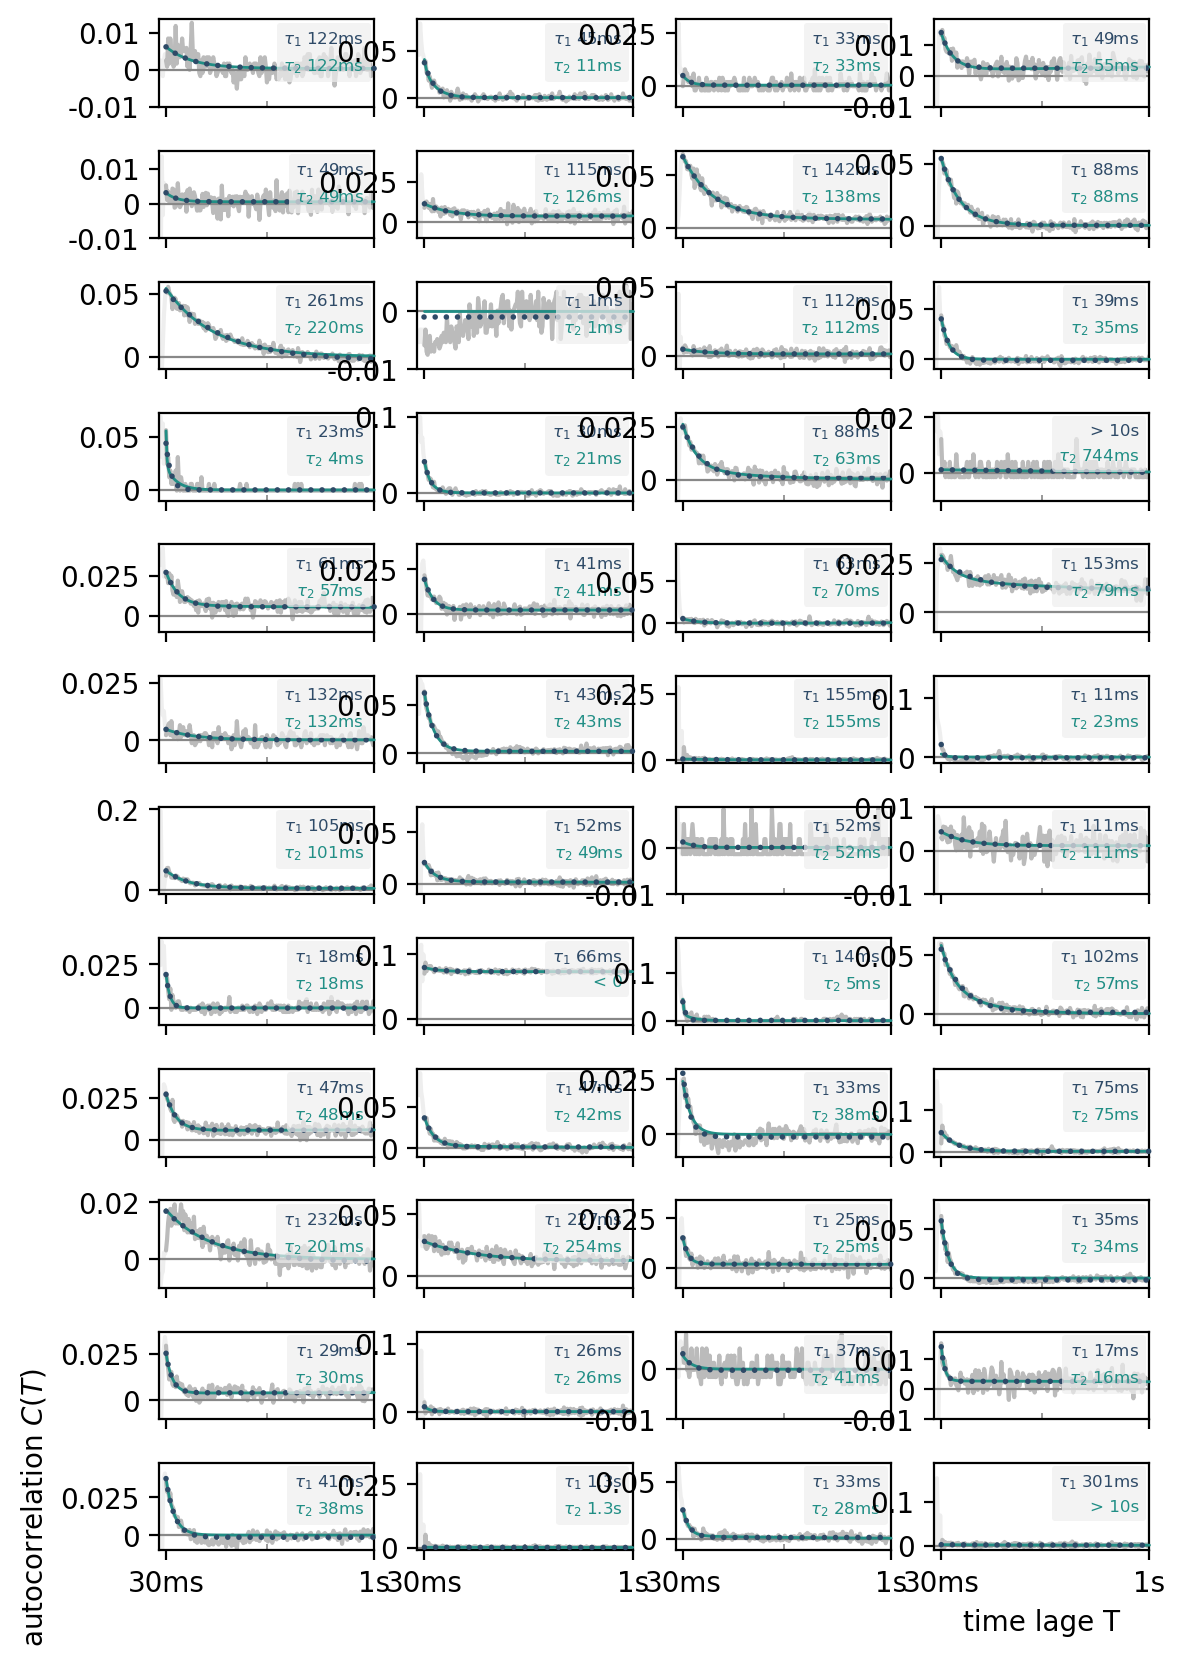

In [84]:
# fine, works.
# lets only use neurons with status "good"
log.setLevel("INFO")

prepped_filtered = dict()
for k, v in prepped.items():
    if v["status"] == "good":
        prepped_filtered[k] = v

log.info(f"neurons with status 'good': {len(prepped_filtered)}")

# one page is digestable
page_width = 17 / 2.54
page_height = 24 / 2.54
num_cols = 4
num_rows = 12

fig, axes = plt.subplots(
    num_rows,
    num_cols,
    figsize=(page_width, page_height),
    gridspec_kw=dict(wspace=0.2, hspace=0.5, bottom=0.07, left=0.16),
)

# create a subset we can plot
np.random.seed(43)
selected_nids = np.random.choice(list(prepped_filtered.keys()), num_cols*num_rows, replace=False)

for row_idx in range(0, num_rows):
    for col_idx in range(0, num_cols):
        nid = selected_nids[row_idx*num_cols + col_idx]
        log.info(f"row {row_idx}, col {col_idx}: nid {nid}")
        ax = axes[row_idx, col_idx]
        panel(
            _binned_spike_count(prepped_filtered[nid]["spikes"], bin_size=5/1000),
            tmin=30/1000,
            tmax=1,
            bin_size=5/1000,
            ax=ax,
            # legtitle=f"{nid}", # neuron id as legend title. takes too much space
        )
        ax.set_ylim(-0.01, None)


    # only show x ticks on the bottom row
    if row_idx < num_rows - 1:
        for ax in axes[row_idx, :]:
            ax.tick_params(axis="x", labelbottom=False)

try:
    # requires matplotlib >= 3.4
    fig.supylabel(r'autocorrelation $C(T)$')
    fig.supxlabel(r'time lage T')
except:
    axes[-1, 0].set_ylabel(r'autocorrelation $C(T)$')
    axes[-1, -1].set_xlabel(r'time lage T')

plt.savefig()
# fig.tight_layout() # not compatible with manual grid spec?


In [83]:
fig.savefig(
    "single_unit_fit_overview.pdf",
    dpi=450,
    bbox_inches="tight",
)